# Connect to Mongopy 

In [1]:
""" %pip install pymongo """
from pymongo import MongoClient
import pandas as pd

# Connexion via mongos
client = MongoClient("mongodb://localhost:27018")

db = client["ami_politique"]
collection = db["articles"]

# Charger les données dans un DataFrame
cursor = collection.find({}, {
    "_id": 0,
    "title": 1,
    "datetime": 1,
    "tag": 1,
    "article_body": 1
})

df = pd.DataFrame(list(cursor))
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

df.head()


,tag,title,datetime,article_body
0,Politique,Le Parti Ravah commémore la journée internatio...,2022-04-29 17:46:09+00:00,"Le Parti Ravah a organisé, vendredi, à son siè..."
1,Politique,Le Parti ‘’El-Islah’’ tient la première sessio...,2021-12-25 21:22:20+00:00,"Le Parti El-Islah a organisé, samedi au Palais..."
2,Politique,Célébration de la Journée des Nations Unies,2021-10-25 14:05:34+00:00,"Le ministère des Affaires étrangères, de la Co..."
3,Politique,Ministère de la Fonction publique: Célébration...,2021-06-28 12:59:44+00:00,Le Ministre de la Fonction publique et du Trav...
4,Politique,Le RFD exprime son soutien au peuple palestinien,2021-05-20 21:25:29+00:00,Le président du parti du Rassemblement des For...


# Chargement des bibliotheques

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from textblob import TextBlob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

# Use ggplot-like styling for a clean, academic look
plt.style.use("ggplot")

 # Visualisations des Donnes

### Most Frequent Words (Bar Chart)

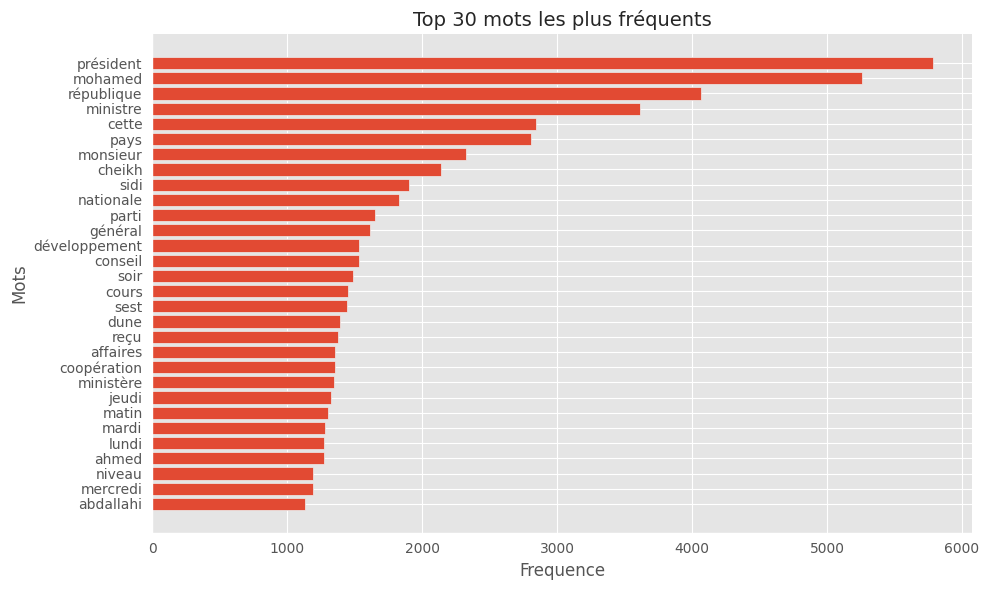

In [14]:


plt.style.use("ggplot")  # ggplot-like theme

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

all_text = " ".join(df["article_body"].astype(str))
all_text = clean_text(all_text)

words = all_text.split()

stopwords = set([
    "le", "la", "et", "les", "des", "de", "deux", "entre", "plus", "parmi",
    "du", "un", "une", "en", "à", "que", "qui", "pour", "mauritanie",
    "dans", "sur", "au", "aux", "par", "avec", "ce", "ces",
    "il", "elle", "ils", "elles", "ne", "pas", "se", "sa",
    "son", "ses", "ould", "nouakchott"
])

words = [w for w in words if w not in stopwords and len(w) > 3]

word_freq = Counter(words).most_common(30)

labels, values = zip(*word_freq)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(labels[::-1], values[::-1])  # horizontal + sorted
ax.set_title("Top 30 mots les plus fréquents", fontsize=14)
ax.set_xlabel("Frequence")
ax.set_ylabel("Mots")

# Remove clutter
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### Sentiment Trend Over Time

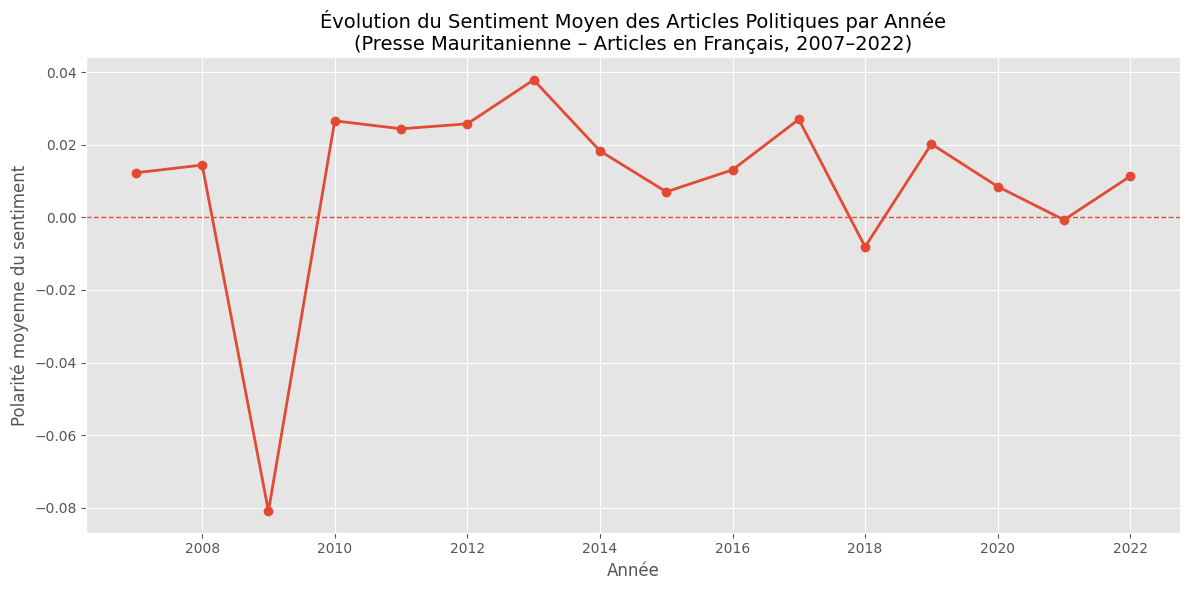

In [6]:
# ---------------------------------------------------------
# Visualization 5: Sentiment Analysis Over Time
# ---------------------------------------------------------
# This visualization tracks the evolution of average sentiment
# in political articles over time (by year).
#
# Sentiment is computed using TextBlob polarity scores:
#   - Range: [-1, 1]
#   - Negative values → negative tone
#   - Positive values → positive tone
#
# The yearly average allows us to observe long-term trends
# and potential correlations with political events.
# ---------------------------------------------------------




# ---- Date handling ----
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["year"] = df["datetime"].dt.year

# ---- Sentiment analysis ----
# Convert text to string to avoid errors on missing values
df["sentiment"] = df["article_body"].apply(
    lambda text: TextBlob(str(text)).sentiment.polarity
)

# ---- Aggregate sentiment by year ----
yearly_sentiment = (
    df.groupby("year", as_index=False)["sentiment"]
    .mean()
    .sort_values("year")
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    yearly_sentiment["year"],
    yearly_sentiment["sentiment"],
    marker="o",
    linewidth=2
)

# Neutral sentiment reference line
ax.axhline(0, linestyle="--", linewidth=1)

# Titles and labels
ax.set_title(
    "Évolution du Sentiment Moyen des Articles Politiques par Année\n"
    "(Presse Mauritanienne – Articles en Français, 2007–2022)",
    fontsize=14
)
ax.set_xlabel("Année")
ax.set_ylabel("Polarité moyenne du sentiment")

# Remove visual clutter
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


### Topic Modeling with LDA

### Keywords

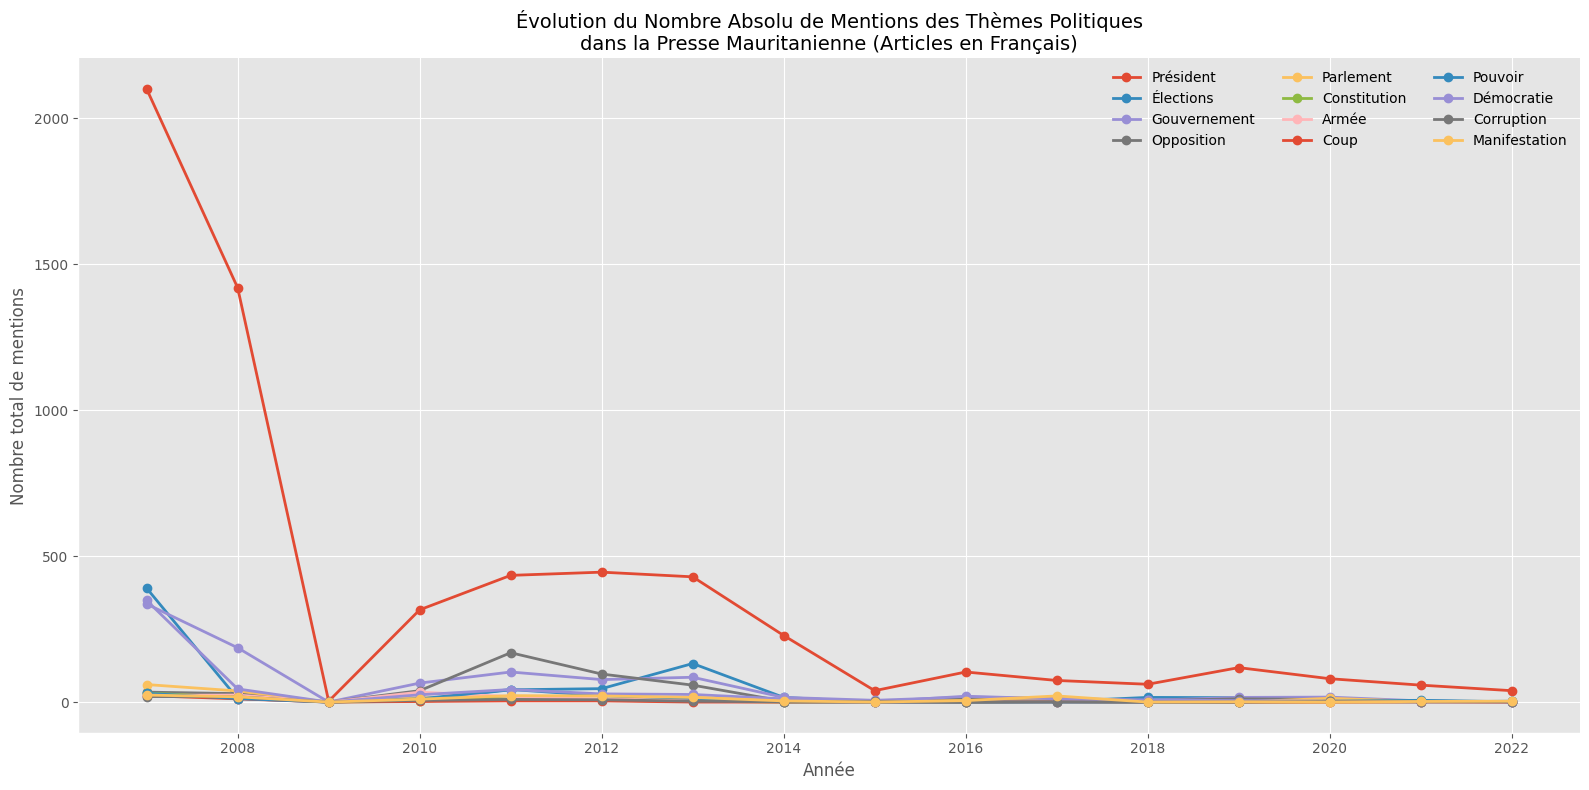

In [8]:
# ---------------------------------------------------------
# Visualization: Evolution of Political Keyword Mentions
# ---------------------------------------------------------
# This figure shows the yearly evolution of the absolute
# number of mentions of key political themes in Mauritanian
# press articles written in French.
#
# The analysis relies on keyword frequency (CountVectorizer)
# and aggregates counts by year to reveal long-term trends
# in political discourse.
# ---------------------------------------------------------


# ---- Date preparation ----
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.dropna(subset=["datetime"])
df["year"] = df["datetime"].dt.year

# ---- Mauritanian political keywords (French) ----
keywords = [
    "président",
    "élections",
    "gouvernement",
    "opposition",
    "parlement",
    "constitution",
    "armée",
    "coup",
    "pouvoir",
    "démocratie",
    "corruption",
    "manifestation"
]

# ---- Vectorization ----
# We restrict the vocabulary to predefined political keywords
vectorizer = CountVectorizer(
    vocabulary=keywords,
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

X = vectorizer.fit_transform(
    df["article_body"].astype(str).str.lower()
)

# Convert to DataFrame for easier manipulation
keyword_df = pd.DataFrame(X.toarray(), columns=keywords)
keyword_df["year"] = df["year"].values

# ---- Yearly aggregation (absolute counts) ----
yearly_mentions = (
    keyword_df
    .groupby("year")[keywords]
    .sum()
    .sort_index()
)

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(16, 8))

for keyword in keywords:
    ax.plot(
        yearly_mentions.index,
        yearly_mentions[keyword],
        marker="o",
        linewidth=2,
        label=keyword.capitalize()
    )

ax.set_title(
    "Évolution du Nombre Absolu de Mentions des Thèmes Politiques\n"
    "dans la Presse Mauritanienne (Articles en Français)",
    fontsize=14
)

ax.set_xlabel("Année")
ax.set_ylabel("Nombre total de mentions")

# Improve legend readability
ax.legend(ncol=3, frameon=False)

# Reduce visual clutter
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


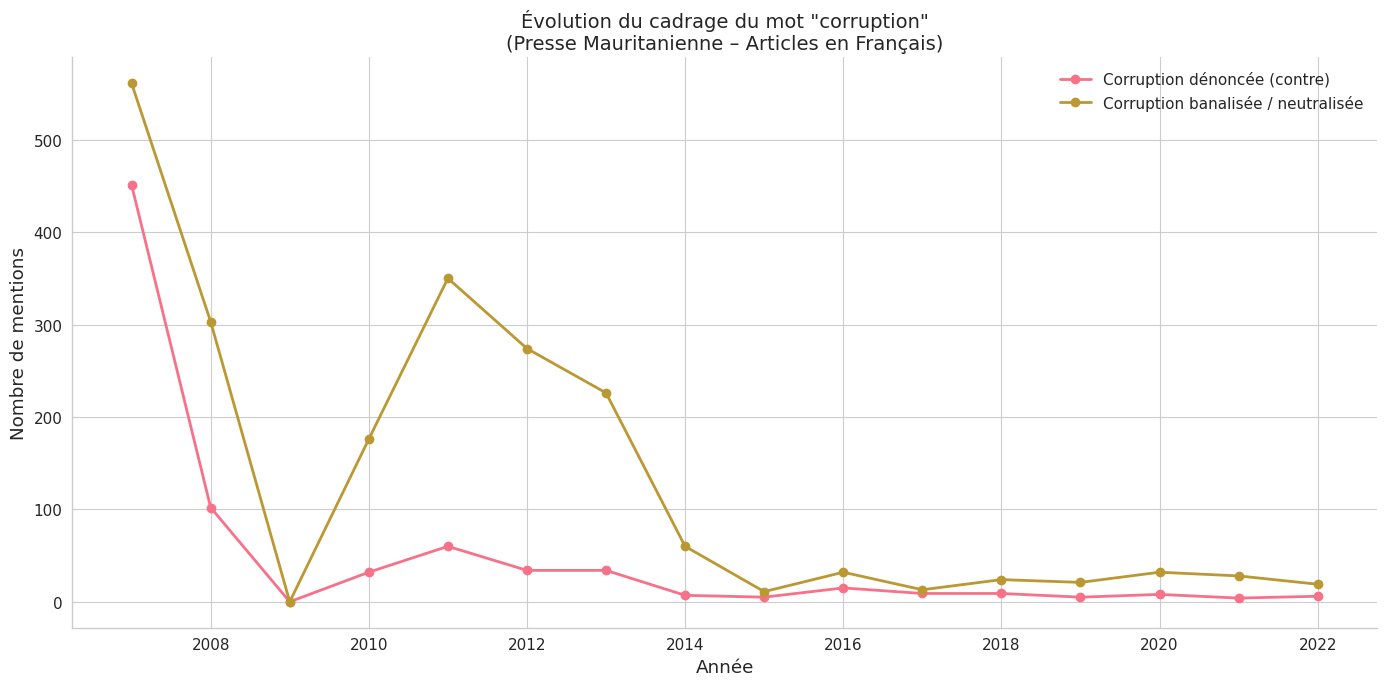

In [13]:
# ---------------------------------------------------------
# Analyse: Corruption dénoncée vs corruption banalisée
# ---------------------------------------------------------
# This visualization tracks how the word "corruption" is framed:
#   - As a problem to be fought (denunciation)
#   - As a normalized or neutral political fact
#
# Mentions are aggregated by year to observe discursive evolution.
# ---------------------------------------------------------

# ---- Keyword groups ----

# Corruption framed as a problem (contre)
contre_corruption = [
    "corruption",
    "dénonce",
    "scandale",
    "abus",
    "détournement",
    "illégal",
    "impunité",
    "justice",
    "enquête",
    "sanction"
]

# Corruption framed as neutral / tolerated
banalisation_corruption = [
    "corruption",
    "affaire",
    "gestion",
    "pratique",
    "système",
    "réseau",
    "pouvoir",
    "politique",
    "administration"
]

all_keywords = list(set(contre_corruption + banalisation_corruption))

# ---- Vectorization ----
vectorizer = CountVectorizer(
    vocabulary=all_keywords,
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

X = vectorizer.fit_transform(df["article_body"].astype(str).str.lower())

df_kw = pd.DataFrame(X.toarray(), columns=all_keywords)
df_kw["year"] = df["year"].values

# ---- Aggregate yearly counts ----
yearly = df_kw.groupby("year")[all_keywords].sum().sort_index()

# Approximate framing counts
yearly["corruption_contre"] = yearly[contre_corruption].sum(axis=1)
yearly["corruption_banalisee"] = yearly[banalisation_corruption].sum(axis=1)

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    yearly.index,
    yearly["corruption_contre"],
    label="Corruption dénoncée (contre)",
    marker="o",
    linewidth=2
)

ax.plot(
    yearly.index,
    yearly["corruption_banalisee"],
    label="Corruption banalisée / neutralisée",
    marker="o",
    linewidth=2
)

ax.set_title(
    'Évolution du cadrage du mot "corruption"\n'
    '(Presse Mauritanienne – Articles en Français)',
    fontsize=14
)

ax.set_xlabel("Année")
ax.set_ylabel("Nombre de mentions")

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


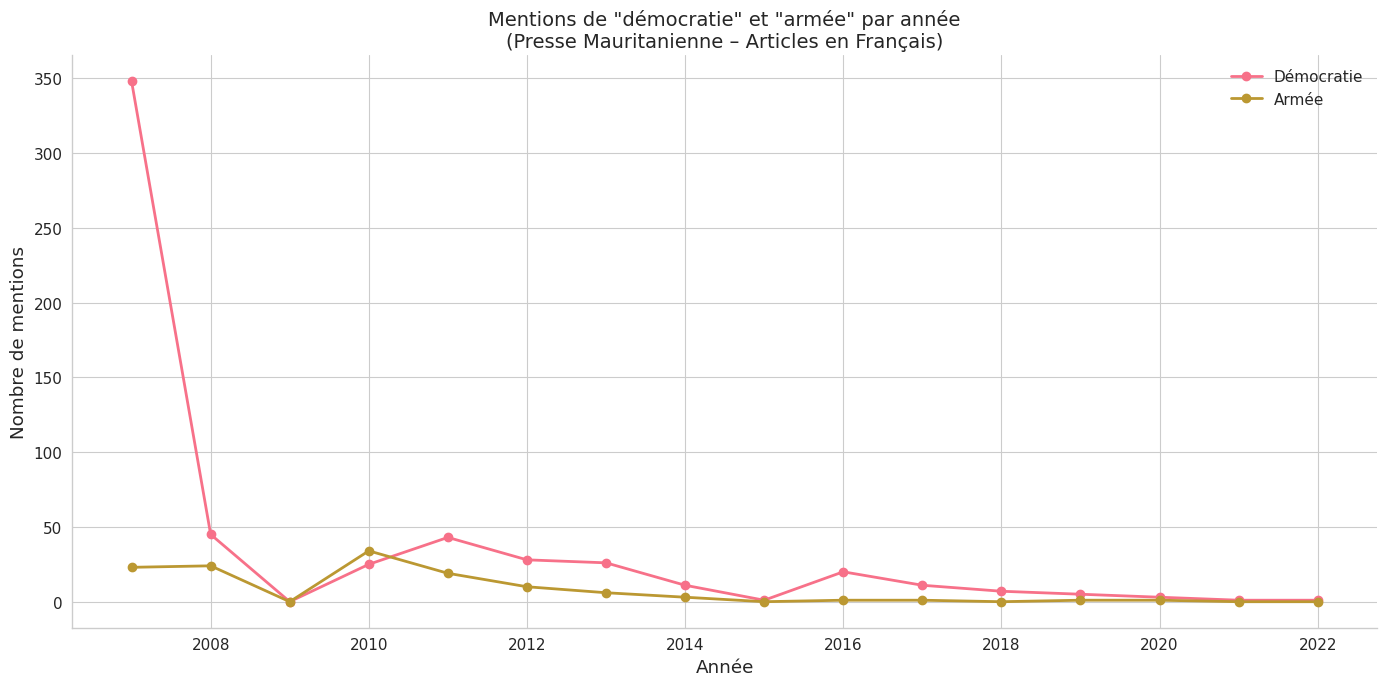

In [10]:
# ---------------------------------------------------------
# Visualisation 12: Comparison of "démocratie" vs "armée"
# ---------------------------------------------------------
# This figure compares the yearly frequency of two central
# political concepts in Mauritanian press discourse:
#   - Democratic discourse ("démocratie")
#   - Military influence ("armée")
#
# Absolute keyword mentions are aggregated by year to
# highlight long-term trends and shifts in emphasis.
# ---------------------------------------------------------

# ---- Keywords of interest ----
keywords = ["démocratie", "armée"]

# ---- Vectorization (restricted vocabulary) ----
vectorizer = CountVectorizer(
    vocabulary=keywords,
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

X = vectorizer.fit_transform(
    df["article_body"].astype(str).str.lower()
)

# Convert to DataFrame
df_keywords = pd.DataFrame(X.toarray(), columns=keywords)
df_keywords["year"] = df["year"].values

# ---- Aggregate counts by year ----
yearly_mentions = (
    df_keywords
    .groupby("year")[keywords]
    .sum()
    .sort_index()
)

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    yearly_mentions.index,
    yearly_mentions["démocratie"],
    label="Démocratie",
    marker="o",
    linewidth=2
)

ax.plot(
    yearly_mentions.index,
    yearly_mentions["armée"],
    label="Armée",
    marker="o",
    linewidth=2
)

ax.set_title(
    'Mentions de "démocratie" et "armée" par année\n'
    '(Presse Mauritanienne – Articles en Français)',
    fontsize=14
)

ax.set_xlabel("Année")
ax.set_ylabel("Nombre de mentions")

# Improve readability
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


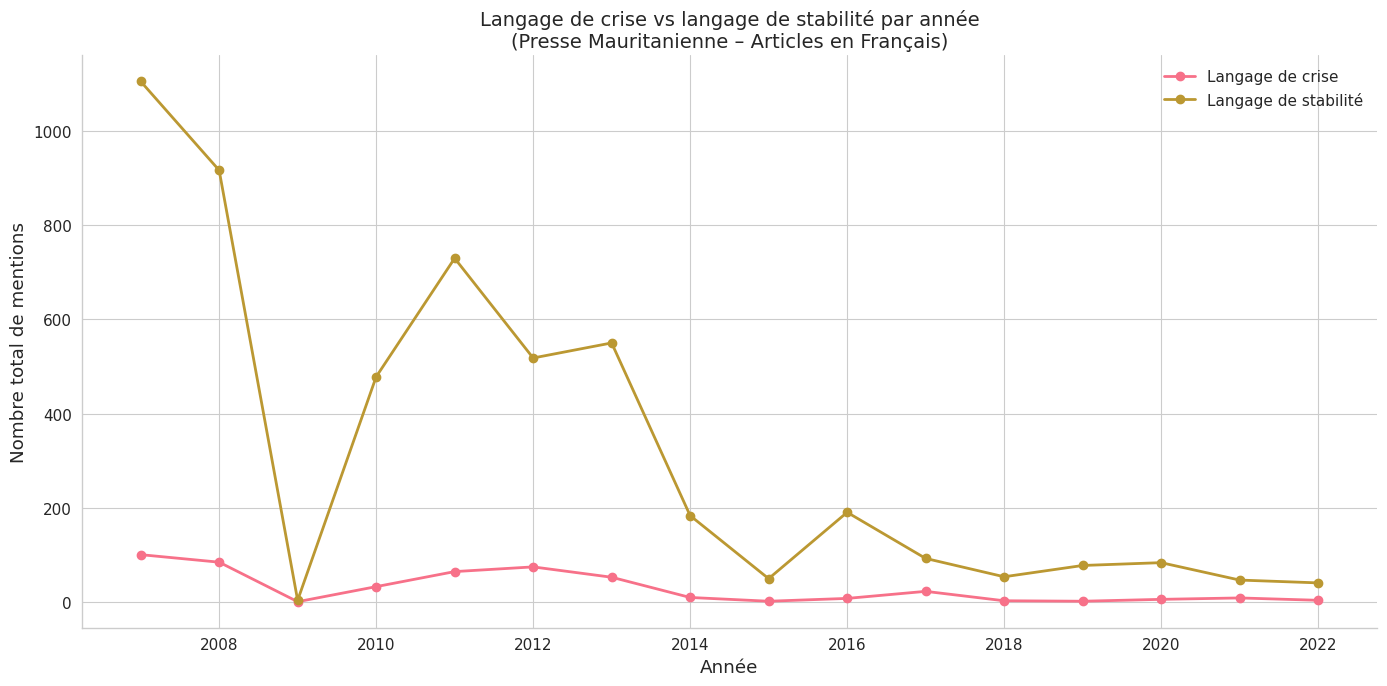

In [11]:
# ---------------------------------------------------------
# Visualisation: Langage de crise vs langage de stabilité
# ---------------------------------------------------------
# This figure compares the evolution of two types of political
# discourse in Mauritanian press articles:
#   - Crisis language (instability, conflict, breakdown)
#   - Stability language (order, continuity, governance)
#
# The analysis is based on absolute keyword mentions aggregated
# by year.


# ---- Keyword groups ----
crisis_keywords = [
    "crise",
    "tension",
    "conflit",
    "violence",
    "instabilité",
    "coup",
    "manifestation",
    "répression",
    "chaos",
    "urgence"
]

stability_keywords = [
    "stabilité",
    "paix",
    "sécurité",
    "ordre",
    "réforme",
    "dialogue",
    "développement",
    "institution",
    "gouvernance",
    "coopération"
]

all_keywords = crisis_keywords + stability_keywords

# ---- Vectorization (restricted vocabulary) ----
vectorizer = CountVectorizer(
    vocabulary=all_keywords,
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

X = vectorizer.fit_transform(
    df["article_body"].astype(str).str.lower()
)

# Convert to DataFrame
keywords_df = pd.DataFrame(X.toarray(), columns=all_keywords)
keywords_df["year"] = df["year"].values

# ---- Aggregate yearly counts ----
yearly_counts = keywords_df.groupby("year")[all_keywords].sum().sort_index()

# Sum by discourse type
yearly_counts["langage_crise"] = yearly_counts[crisis_keywords].sum(axis=1)
yearly_counts["langage_stabilite"] = yearly_counts[stability_keywords].sum(axis=1)

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    yearly_counts.index,
    yearly_counts["langage_crise"],
    label="Langage de crise",
    marker="o",
    linewidth=2
)

ax.plot(
    yearly_counts.index,
    yearly_counts["langage_stabilite"],
    label="Langage de stabilité",
    marker="o",
    linewidth=2
)

ax.set_title(
    "Langage de crise vs langage de stabilité par année\n"
    "(Presse Mauritanienne – Articles en Français)",
    fontsize=14
)

ax.set_xlabel("Année")
ax.set_ylabel("Nombre total de mentions")

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


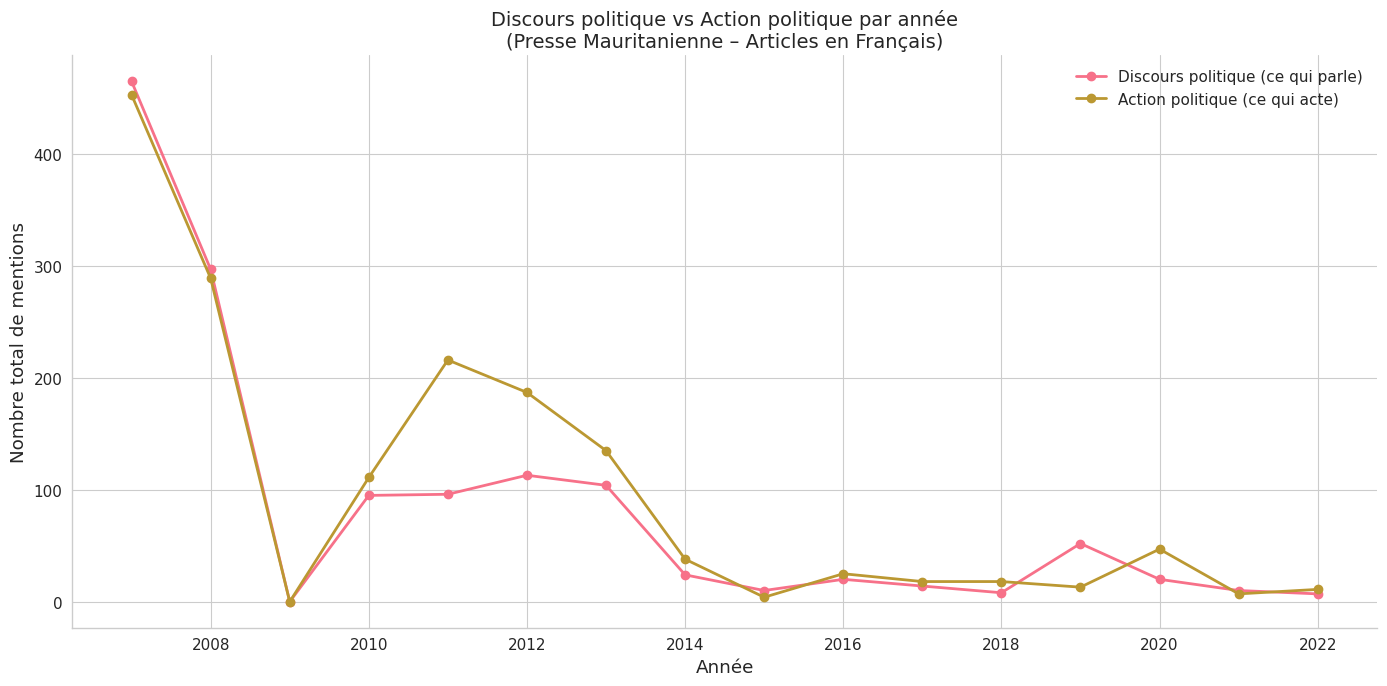

In [12]:
# ---------------------------------------------------------
# Visualisation: Discours politique vs Action politique
# ---------------------------------------------------------
# This figure contrasts two modes of political communication:
#   - Discours: statements, promises, declarations, rhetoric
#   - Action: concrete measures, decisions, implementation
#
# Keyword frequencies are aggregated by year to observe
# shifts between symbolic politics and effective action.
# ---------------------------------------------------------

# ---- Keyword groups ----
discours_keywords = [
    "discours",
    "déclaration",
    "annonce",
    "promesse",
    "engagement",
    "affirmé",
    "souligne",
    "déclare",
    "appel",
    "message"
]

action_keywords = [
    "décision",
    "adoption",
    "mise",
    "application",
    "réforme",
    "loi",
    "décret",
    "mesure",
    "mise en œuvre",
    "exécution"
]

# ⚠ Note: "mise en œuvre" will be approximated by separate tokens
all_keywords = discours_keywords + action_keywords

# ---- Vectorization ----
vectorizer = CountVectorizer(
    vocabulary=all_keywords,
    lowercase=True,
    token_pattern=r"\b\w+\b"
)

X = vectorizer.fit_transform(
    df["article_body"].astype(str).str.lower()
)

# Convert to DataFrame
keywords_df = pd.DataFrame(X.toarray(), columns=all_keywords)
keywords_df["year"] = df["year"].values

# ---- Yearly aggregation ----
yearly_counts = (
    keywords_df
    .groupby("year")[all_keywords]
    .sum()
    .sort_index()
)

# Aggregate by discourse type
yearly_counts["discours"] = yearly_counts[discours_keywords].sum(axis=1)
yearly_counts["action"] = yearly_counts[action_keywords].sum(axis=1)

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(
    yearly_counts.index,
    yearly_counts["discours"],
    label="Discours politique (ce qui parle)",
    marker="o",
    linewidth=2
)

ax.plot(
    yearly_counts.index,
    yearly_counts["action"],
    label="Action politique (ce qui acte)",
    marker="o",
    linewidth=2
)

ax.set_title(
    "Discours politique vs Action politique par année\n"
    "(Presse Mauritanienne – Articles en Français)",
    fontsize=14
)

ax.set_xlabel("Année")
ax.set_ylabel("Nombre total de mentions")

ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
